<a href="https://colab.research.google.com/github/mtoriik/Trial/blob/master/Iterative_RNA_Angles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install Biopython

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import figure
from google.colab import drive
drive.mount('/content/drive')
from Bio.PDB import *
import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# structure_list = ["/content/drive/MyDrive/Data Discovery/5osg.pdb"]
# for i in range(len(structure_list)):
#   p=PDBParser()
#   structure_ID = re.findall('\/content\/drive\/MyDrive\/Data Discovery\/([\w]+).pdb', structure_list[i])
#   structure=p.get_structure(structure_ID[0], structure_list[i])

In [ ]:
def read_pdb(structure):
  series_list = []
  for model in structure:
    for chain in model:
      i = 0
      for residue in chain:
        for atom in residue:
          if not('P' in atom.get_name()) and not("'" in atom.get_name()) and (len(residue.resname) == 1):
            nucleotide_dictionary = {'Structure': structure.id, 'Chain': chain.id, 'Residue': residue.resname + str(residue.get_id()[1]), 'Atom' : atom.get_name(), 'Coordinates': atom.get_coord()}
            ser = pd.Series(nucleotide_dictionary)
            series_list.append(ser)
        i += 1

  rna_df = pd.DataFrame.from_dict(series_list, orient = "columns")
  return rna_df

In [ ]:
# df_final = read_pdb(structure)
# unique_residues = df_final['Residue'].unique()
# df_final
#second for loop = through unique residues

,Structure,Chain,Residue,Atom,Coordinates
0,5osg,2,U194,N1,"[57.573, 113.454, 22.003]"
1,5osg,2,U194,C2,"[58.167, 113.626, 23.247]"
2,5osg,2,U194,O2,"[58.195, 114.717, 23.815]"
3,5osg,2,U194,N3,"[58.735, 112.465, 23.789]"
4,5osg,2,U194,C4,"[58.804, 111.196, 23.184]"
...,...,...,...,...,...
798,5osg,2,U951,N3,"[32.975, 105.836, 59.746]"
799,5osg,2,U951,C4,"[32.998, 105.233, 58.475]"
800,5osg,2,U951,O4,"[32.037, 105.318, 57.707]"
801,5osg,2,U951,C5,"[34.226, 104.535, 58.186]"


In [ ]:
def prep_rotate(df, frame):
  int_df = df[df['Residue'] == frame]
  plane_df = int_df[(int_df['Atom'].str.contains('1')) | (int_df['Atom'].str.contains('3')) | (int_df['Atom'].str.contains('5'))]
  x1, y1, z1 = plane_df.iloc[0]['Coordinates'][0], plane_df.iloc[0]['Coordinates'][1], plane_df.iloc[0]['Coordinates'][2]
  x2, y2, z2 = plane_df.iloc[1]['Coordinates'][0], plane_df.iloc[1]['Coordinates'][1], plane_df.iloc[1]['Coordinates'][2]
  x3, y3, z3 = plane_df.iloc[2]['Coordinates'][0], plane_df.iloc[2]['Coordinates'][1], plane_df.iloc[2]['Coordinates'][2]
  return rotate_plane(df, x1, y1, z1, x2, y2, z2, x3, y3, z3)

# f = prep_rotate(df_final, 'U194')
# print(len(f))

In [ ]:
def rotate_plane(df, x1, y1, z1, x2, y2, z2, x3, y3, z3):

    a1 = x2 - x1
    b1 = y2 - y1
    c1 = z2 - z1
    a2 = x3 - x1
    b2 = y3 - y1
    c2 = z3 - z1
    a = b1 * c2 - b2 * c1
    b = a2 * c1 - a1 * c2
    c = a1 * b2 - b1 * a2
    d = (- a * x1 - b * y1 - c * z1)
    # print("equation of plane is ",a, "x +",
    #       b, "y +",
    #       c, "z +",
    #       d, "= 0.")

    u = 1/np.sqrt(np.square(a) + np.square(b)) * np.array([b, -a, 0])
    u1 = u[0]
    u2 = u[1]
    cos = c/np.sqrt(np.square(a) + np.square(b) + np.square(c))
    sin = np.sqrt((np.square(a) + np.square(b))/(np.square(a)+np.square(b)+np.square(c)))

    rot_matrix = [
        [cos + np.square(u1)*(1-cos), u1*u2*(1-cos), u2*sin],
        [u1*u2*(1-cos), cos + np.square(u2)*(1-cos), -u1*sin],
        [-u2*sin, u1*sin, cos]
    ]
    x_ar = []
    y_ar = []
    z_ar = []
    rotated_points = []
    for i in range(len(df)):
      coord = df['Coordinates'].iloc[i]
      coord[2] += d/c
      product = np.dot(rot_matrix, coord)
      x_ar.append(product[0])
      y_ar.append(product[1])
      z_ar.append(product[2])
      rotated_points.append(product)

    df['Rotated Coordinates'] = rotated_points
    return df

# U_194_df = df_final[df_final['Residue'] == 'U194']
# U_194_df.iloc[2]['Coordinates'][0]

# x1, y1, z1 = U_194_df.iloc[0]['Coordinates'][0], U_194_df.iloc[0]['Coordinates'][1], U_194_df.iloc[0]['Coordinates'][2]
# x2, y2, z2 = U_194_df.iloc[1]['Coordinates'][0], U_194_df.iloc[1]['Coordinates'][1], U_194_df.iloc[1]['Coordinates'][2]
# x3, y3, z3 = U_194_df.iloc[2]['Coordinates'][0], U_194_df.iloc[2]['Coordinates'][1], U_194_df.iloc[2]['Coordinates'][2]
# rotated_array = rotate_plane(df_final, x1, y1, z1, x2, y2, z2, x3, y3, z3)
# rotated_array[['Residue','Atom','Rotated Coordinates']]

In [ ]:
#getting the filtered dataframe
def z_filter(rna_df, z_threshold):
  rna_df['Rotated X Coord'] = rna_df['Rotated Coordinates'].apply(lambda x: x[0])
  rna_df['Rotated Y Coord'] = rna_df['Rotated Coordinates'].apply(lambda x: x[1])
  rna_df['Rotated Z Coord'] = rna_df['Rotated Coordinates'].apply(lambda x: x[2])

  z_filter = rna_df[np.abs(rna_df['Rotated Z Coord']) <= z_threshold]
  drop_array = []
  for i in z_filter.index:
    # print(z_filter['Residue'][i])
    if 'A' in z_filter['Residue'][i] or 'G' in z_filter['Residue'][i]:
      if '4' in z_filter['Atom'][i] or '1' in z_filter['Atom'][i]:
        continue
      else:
        drop_array.append(i)
    if 'C' in z_filter['Residue'][i] or 'U' in z_filter['Residue'][i]:
      if '6' in z_filter['Atom'][i] or '3' in z_filter['Atom'][i]:
        continue
      else:
        drop_array.append(i)
  z_filter = z_filter.drop(drop_array)

  count_freq = dict(z_filter['Residue'].value_counts())
  z_filter_two = z_filter.copy()
  z_filter_two['count_freq'] = z_filter_two['Residue']
  z_filter_two['count_freq'] = z_filter_two['count_freq'].map(count_freq)
  z_filter_two = z_filter_two[z_filter_two.count_freq>1]

  return z_filter_two

In [ ]:
# d = f.copy()
# z = z_filter(f, 1)
# z.head(10)

,Structure,Chain,Residue,Atom,Coordinates,Rotated Coordinates,Rotated X Coord,Rotated Y Coord,Rotated Z Coord,count_freq
3,5osg,2,U194,N3,"[58.735, 112.465, 167.88362]","[159.9252648918146, 136.77351754439377, -0.010...",159.925265,136.773518,-0.010712,2
7,5osg,2,U194,C6,"[57.631, 112.24, 165.44362]","[157.30424497683543, 136.1840916578735, -0.087...",157.304245,136.184092,-0.087420,2


In [ ]:
def translated_2D(df, frame):
  # print(df[df['Residue'] == frame].iloc[1]['Rotated X Coord'])
  reference_x = df[df['Residue'] == frame].iloc[1]['Rotated X Coord']
  reference_y = df[df['Residue'] == frame].iloc[1]['Rotated Y Coord']
  df['X Translated'] = df['Rotated X Coord'] - reference_x
  df['Y Translated'] = df['Rotated Y Coord'] - reference_y
  return df

# g = translated_2D(z, 'U195')
# g.head()

In [ ]:
def rotate_2D(df, frame):
  def rot_matrix_2D(y_coord, x_coord):
    if x_coord > 0:
      theta = np.arctan(y_coord / x_coord)
    else:
      theta = np.arctan(y_coord / x_coord) + np.pi
    rot_mat = np.array([np.cos(-theta), -np.sin(-theta), np.sin(-theta), np.cos(-theta)]).reshape(2,2)
    return rot_mat

  translated_df = translated_2D(df, frame)
  y_reference = translated_df[translated_df['Residue'] == frame].iloc[0]['Y Translated']
  x_reference = translated_df[translated_df['Residue'] == frame].iloc[0]['X Translated']
  rotation_matrix = rot_matrix_2D(y_reference, x_reference)
  # reference_points = np.array([[x_reference, y_reference]]).T

  x_coords_list = []
  y_coords_list = []
  for i in range(len(df)):
    x_coord_point = df['X Translated'].iloc[i]
    y_coord_point = df['Y Translated'].iloc[i]
    rotated_points = (np.dot(rotation_matrix, np.array([x_coord_point, y_coord_point])))
    x_coords_list.append(rotated_points[0])
    y_coords_list.append(rotated_points[1])

  df_with_rot = df.copy()
  df_with_rot['Vector X Coord'] = x_coords_list
  df_with_rot['Vector Y Coord'] = y_coords_list
  return df_with_rot.sort_index()

# rot_rot = rotate_2D(z, 'U195')
# rot_rot.head(10)

In [ ]:
def polar(df, radius_threshold):
  singular_point_df = df.groupby('Residue')[['Vector X Coord', 'Vector Y Coord']].mean()
  singular_point_df['R'] = np.sqrt((singular_point_df['Vector X Coord'] ** 2) + (singular_point_df['Vector Y Coord'] ** 2))
  theta = []
  for i in range(len(singular_point_df)):
    if singular_point_df['Vector X Coord'].iloc[i] > 0:
      theta.append(np.arctan(singular_point_df['Vector Y Coord'].iloc[i] / singular_point_df['Vector X Coord']).iloc[i])
    else:
      theta.append(np.arctan(singular_point_df['Vector Y Coord'].iloc[i] / singular_point_df['Vector X Coord']).iloc[i] + np.pi)
  singular_point_df['Theta'] = theta
  filtered_radii = singular_point_df[singular_point_df['R'] <= radius_threshold]
  return filtered_radii

# pp = polar(rot_rot, 10)
# pp.head(10)

In [ ]:
def df_to_dictionary(polar_df, coordinate_df, frame):
  polar_intermediate = polar_df.reset_index()
  singular_residue_coordinate_df = coordinate_df.groupby('Residue').first()
  merged_polar_overall = polar_intermediate.merge(singular_residue_coordinate_df, left_on = 'Residue', right_on = 'Residue')[['Structure', 'Chain', 'Residue', 'R', 'Theta']]
  merged_polar_overall['Reference Residue'] = frame
  return merged_polar_overall.to_dict('records')


# dictionary = df_to_dictionary(pp, rot_rot, 'U194')
# print(dictionary)
# dataframe = pd.DataFrame(dictionary)
# dataframe

#want to output dataframe with structure_id, chain_idf, reference residue, chain_id, residue, R, theta
# return pd.json_normalize(merged_polar_overall,)


In [ ]:
structure_list = ["/content/drive/MyDrive/Data Discovery/5osg.pdb", "/content/drive/MyDrive/Data Discovery/1a9n.pdb"]
def pipeline(structures_list, z_threshold, radius_threshold):
  overall_df_list = []
  for i in range(len(structures_list)):
    p=PDBParser()
    structure_ID = re.findall('\/content\/drive\/MyDrive\/Data Discovery\/([\w]+).pdb', structures_list[i])
    structure=p.get_structure(structure_ID[0], structures_list[i])


    readin_pdb_df = read_pdb(structure)
    unique_residues = readin_pdb_df['Residue'].unique()
    for reference_frame in unique_residues:
      rotated_plane_df = prep_rotate(readin_pdb_df, reference_frame)
      filtered_rotated_plane_df = z_filter(rotated_plane_df, z_threshold)
      rotated_vector_df = rotate_2D(filtered_rotated_plane_df, reference_frame)
      polar_coordinates = polar(rotated_vector_df, radius_threshold)
      overall_df_list.append(df_to_dictionary(polar_coordinates, rotated_vector_df, reference_frame))

  concatenated_df = pd.DataFrame(overall_df_list[0])
  i = 1
  while i < len(overall_df_list):
    dataframe = pd.DataFrame(overall_df_list[i])
    concatenated_df = pd.concat([concatenated_df, dataframe], sort = False)
    i += 1

  concatenated_df = concatenated_df.reset_index().drop(columns = {'index'})
  filtered_df = concatenated_df[(concatenated_df['Residue'] == concatenated_df['Reference Residue'])]
  no_repeats_df = concatenated_df[~concatenated_df.isin(filtered_df)].dropna()
  return no_repeats_df


#first for loop = through structures

# for i in trial_1:
#   print(i)
#   dataframe = pd.DataFrame(i)
#   dataframe.head()

In [ ]:
trial_1 = pipeline(structure_list, 1, 10)
# trial_1.head(10)

In [ ]:
trial_1

,Structure,Chain,Residue,R,Theta,Reference Residue
1,5osg,2,A231,6.958014,-0.184696,U195
4,5osg,2,A229,6.743670,-0.206765,U197
7,5osg,2,G228,7.014634,-0.033780,C198
9,5osg,2,G226,7.558035,0.040018,C199
13,5osg,2,C198,6.974039,-0.018486,G228
16,5osg,2,C196,6.683117,-0.094297,G230
23,5osg,2,A255,5.743877,4.485276,A256
28,5osg,2,G948,7.067143,-0.163006,C259
30,5osg,2,U947,7.059186,0.126758,A260
32,5osg,2,U946,6.824952,-0.013252,A261


In [ ]:
print(np.degrees(trial_1['Theta']), trial_1['R'])

1      -10.582306
4      -11.846752
7       -1.935468
9        2.292838
13      -1.059151
16      -5.402801
23     256.987403
28      -9.339561
30       7.262673
32      -0.759264
33     -26.243856
35      -0.990888
37      71.065308
39     -14.487525
41      -4.999172
47      24.171821
50      17.139210
54     -31.055765
56       4.757633
66     134.930501
70     122.860127
78     253.086771
82      -5.249422
86     124.958516
94       8.922458
100     14.237294
101    -80.673179
105    -27.218368
110    -16.585170
111     -5.173759
113      8.255759
116     -2.645480
118     -2.218265
123     -3.644633
124     -5.042586
126      4.809066
128      2.634319
130    -20.368125
144     19.791744
146     -2.568577
148     -2.355728
150      6.920297
151     -1.103674
Name: Theta, dtype: float64 1      6.958014
4      6.743670
7      7.014634
9      7.558035
13     6.974039
16     6.683117
23     5.743877
28     7.067143
30     7.059186
32     6.824952
33     7.492646
35     7.271253
37    

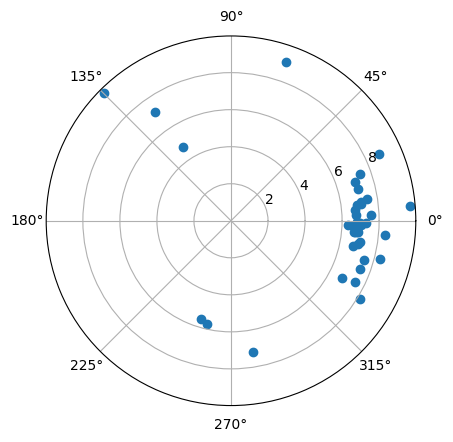

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection = 'polar')
ax.scatter(trial_1['Theta'], trial_1['R'])

<Axes: xlabel='Theta', ylabel='R'>

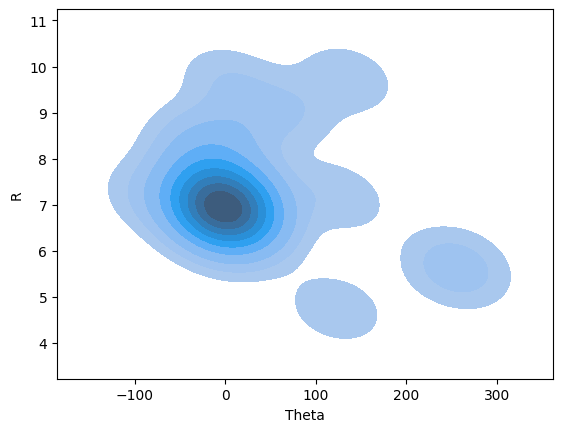

In [ ]:
import seaborn as sns
sns.kdeplot(data = trial_1, x = np.degrees(trial_1['Theta']), y = trial_1['R'], fill = True)

[-0.18469608 -0.20676482 -0.03378028  0.04001757 -0.01848566 -0.09429667
  4.48527632 -0.1630061   0.12675756 -0.01325165 -0.4580417  -0.01729426
  1.24032361 -0.25285501 -0.08725202  0.42187786  0.29913565 -0.54202535
  0.08303636  2.35498151  2.14431373  4.41719745 -0.0916197   2.18093754
  0.15572627  0.24848765 -1.4080126  -0.47505014 -0.28946583 -0.09029913
  0.14409018 -0.04617233 -0.03871603]


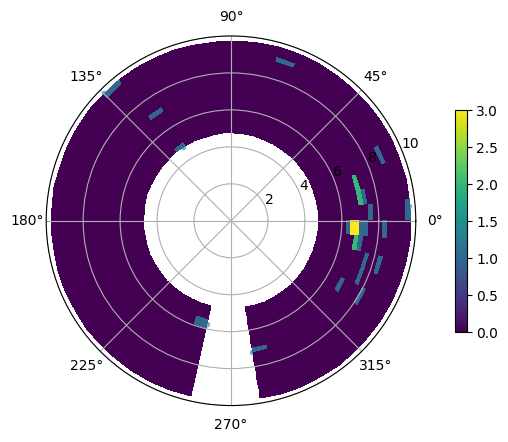

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample polar coordinates (replace this with your data)
theta = trial_1['Theta'].values
theta_range = np.append(0, theta)
r = trial_1['R'].values
r_range = np.append(0, r)

# Create a polar scatter plot
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.scatter(theta, r, alpha=0.5, marker='.')

# Create a 2D histogram for density
hist, theta_edges, r_edges = np.histogram2d(theta, r, bins=(50, 20))
theta_centers = np.radians((theta_edges[:-1] + theta_edges[1:]) / 2)
r_centers = (r_edges[:-1] + r_edges[1:]) / 2

# Plot the density plot in polar coordinates using pcolormesh
contourplot = ax.pcolormesh(theta_edges, r_edges, hist.T, cmap='viridis')

ax.set_rmax(10.0)  # Set the maximum value for the radial axis
ax.set_rmin(0.0)

# Add colorbar
plt.colorbar(contourplot, shrink=0.6, pad=0.08)

print(theta)
plt.show()